# Tutorial Part 4: Back and forth conversion of AIM and MHA and saving the images

Author: *Jilmen Quintiens* <br>
Created: *17 Jan 2024* <br>
Last modified: *17 Jan 2024* <br>

## Aim of the tutorial

In this tutorial, we'll read in an AIM file, convert it to an image MHA image while also change the image unit, and transform it back to an AIM image in the native image unit. This way, processing of AIM files can be done independently from the Scanco system, and outputs can be transformed back to AIM files without losing valid metadata.

## Load in necessary packages

For this tutorial, the reading of AIM files will make use of `vtkbone`. For the manipulation of MHA files, `SimpleITK`is used. Other usefull packages are also loaded:

In [1]:
import vtk
import vtkbone
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import os

We also load the helper functions, originally pulled from the BoneLab repository. For more information on the helper functions, we refer to Part 1 of the Tutorial.

In [2]:
#provides function to read AIM header (in standard format) and pull key values for density calibration
from python_helpers.aim_calibration_header import get_aim_calibration_constants_from_processing_log
from python_helpers.aim_calibration_header import get_aim_density_equation
from python_helpers.aim_calibration_header import get_aim_hu_equation

#provides functions for converting between vtk image data format to a numpy array and back
from python_helpers.vtk_util import vtkImageData_to_numpy, numpy_to_vtkImageData

## From AIM to MHA
### Read in AIM file and convert to SimpleITK image

In order to convert the AIM image to an MHA image, the first step is to read in the AIM and convert the image matrix to a numpy array and a SimpleITK image. For more information on this step, see Tutorial Part 1. For this example, we will rescale the numpy array to a mineral density unit.

In [3]:
#specify file path to image. here we use the example image found in the "/data" subfolder
file_path = "data/TRAB_1240.AIM"

# read in aim image
reader = vtkbone.vtkboneAIMReader()
reader.DataOnCellsOff() 
reader.SetFileName(file_path)
reader.Update()

#here we pull the image data itself along with the header information 
vtk_img = reader.GetOutput()
img_header = reader.GetProcessingLog()

# convert to numpy array
np_image = vtkImageData_to_numpy(vtk_img)

# rescale image to BMD unit
mu_scaling, hu_mu_water, hu_mu_air, density_slope, density_intercept = get_aim_calibration_constants_from_processing_log(img_header)
np_image_scaled = np_image/mu_scaling * density_slope + density_intercept

# convert to SimpleITK
origin = vtk_img.GetOrigin()
spacing = vtk_img.GetSpacing()

np_image_scaled = np.transpose(np_image_scaled)

sitk_img = sitk.GetImageFromArray(np_image_scaled)
sitk_img.SetSpacing(spacing)
sitk_img.SetOrigin(origin)

### Add metadata to SimpleITK image

For future manipulations and backwards compatibility, it is important that the image does not loose its metadata once the conversion to SimpleITK and MHA files are performed. For this reason we add two new metadata entries to the SimpleITK image.

#### Add image header as metadata

The first addition to the metadata is the image header data. We do this with the `SetMetaData` method from the SimpleITK image class. However, for SimpleITK compatibility, metadata may only consist out of string values, and there **cannot** be line breaks in the metadata. Therefore we slightly manipulate the image header string.

In [9]:
sitk_header = img_header.replace('\n', '_LINEBREAK_')
sitk_img.SetMetaData('image_header', sitk_header)

#### Add image unit as metadata

In order to keep track of the unit in which the image values are expressed, we create a new metadata entry for this as well. In our example, the current unit of the SimpleITK image is *BMD*.

In [10]:
sitk_img.SetMetaData('unit','BMD')

### Save SimpleITK image as MHA file

Now that all the metadata is set, such that no metadata information is lost, we can safely save the image as an MHA file. 

In [11]:
sitk.WriteImage(sitk_img, "data/TRAB_1240.mha")

## From MHA to AIM

For this step, we want to convert the MHA file back to AIM. we start by reading in the saved image. This image, read in from file, should have an image unit and a header file in its metadata.

In [12]:
del sitk_img
sitk_img = sitk.ReadImage("data/TRAB_1240.mha")

# checking the meta data keys
keys = sitk_img.GetMetaDataKeys()
print("The metadata keys:")
for k in keys:
    print(k)

The metadata keys:
ITK_InputFilterName
ITK_original_direction
ITK_original_spacing
image_header
unit


### Conversion to numpy

In [22]:
# numpy array
np_image = sitk.GetArrayFromImage(sitk_img)
origin = sitk_img.GetOrigin()
spacing = sitk_img.GetSpacing()

### Restoring the header

We previously adapted the header file such that it had SimpleITK compatibility. Before writing the SimpleITK image back to an AIM file, we need to restore the header to its original state.

In [13]:
header = sitk_img.GetMetaData('image_header')
header = header.replace('_LINEBREAK_', '\n')

print(header)

!
! Processing Log
!
!-------------------------------------------------------------------------------
Created by                    ISQ_TO_AIM (IPL)                                  
Time                          16-APR-2017 20:20:59.67                           
Original file                 dk0:[xtremect2.data.00001237.00005697]d0005679.isq;
Original Creation-Date        14-SEP-2016 15:27:12.18                           
Orig-ISQ-Dim-p                                   2304       2304        168
Orig-ISQ-Dim-um                                139852     139852      10197
!-------------------------------------------------------------------------------
Patient Name                  DBQ_152                                           
Index Patient                                    1237
Index Measurement                                5697
!-------------------------------------------------------------------------------
Site                                               20
Scanner ID      

###  Restoring the native image data

AIMS are always assumed to be in the Scanco scanner's native image data. In order to recalculate the image in this unit, we can make use of the header file and the inverse transformations that were used to rescale the image in Part 1 of this tutorial. Hence, it is important that the current data unit is still stored in the metadata.

In [18]:
unit = sitk_img.GetMetaData('unit')
print(f'unit of sitk image is {unit}')

unit of sitk image is BMD


In [21]:
if unit == 'mu':
        mu_scaling, hu_mu_water, hu_mu_air, density_slope, density_intercept = get_aim_calibration_constants_from_processing_log(header)
        np_image_native = np_image*mu_scaling
    
elif unit == 'HU':
    mu_scaling, hu_mu_water, hu_mu_air, density_slope, density_intercept = get_aim_calibration_constants_from_processing_log(header)
    m, b = get_aim_hu_equation(img_log)
    np_image_native = (np_image-b)/m

elif unit == 'BMD':
    mu_scaling, hu_mu_water, hu_mu_air, density_slope, density_intercept = get_aim_calibration_constants_from_processing_log(header)
    np_image_native = (np_image - density_intercept)*mu_scaling/density_slope

elif unit == 'native':
    np_image_native = np_image

else:
    raise ValueError(f'incorrect image unit specified in metadata: {unit}.')

print('Image converted to native units')

Image converted to native units


### Conversion to VTK

In [25]:
# flip of x and z coordinates for compatibility
np_image_native = np.transpose(np_image_native)

# numpy to vtk
vtk_img = numpy_to_vtkImageData(np_image_native, spacing=spacing, origin=origin, array_type = vtk.VTK_SHORT)

### Writing the AIM

In [26]:
writer = vtkbone.vtkboneAIMWriter()
writer.SetFileName("data/TRAB_1240_from_mha.aim")
writer.SetInputData(vtk_img)
writer.NewProcessingLogOff()  
writer.SetProcessingLog(header)
writer.Update()
writer.Write()

1

## Verification of original AIM and restored AIM 

In the final step of the tutorial, we will show that the the original AIM and the restored AIM from the MHA file are the same file.

### reading in AIMS

In [27]:
reader = vtkbone.vtkboneAIMReader()
reader.DataOnCellsOff() 

# original AIM
reader.SetFileName("data/TRAB_1240.AIM")
reader.Update()
aim_original = reader.GetOutput()
header_original = reader.GetProcessingLog()

# restored AIM
reader.SetFileName('IMG1237_from_mha.aim')
reader.Update()
aim_restore = reader.GetOutput()
header_restore = reader.GetProcessingLog()

### Verifying the header files

In [28]:
print("Original file's header:")
print(header_original)
print('\n')
print("Restored file's header:")
print(header_restore)

Original file's header:
!
! Processing Log
!
!-------------------------------------------------------------------------------
Created by                    ISQ_TO_AIM (IPL)                                  
Time                          16-APR-2017 20:20:59.67                           
Original file                 dk0:[xtremect2.data.00001237.00005697]d0005679.isq;
Original Creation-Date        14-SEP-2016 15:27:12.18                           
Orig-ISQ-Dim-p                                   2304       2304        168
Orig-ISQ-Dim-um                                139852     139852      10197
!-------------------------------------------------------------------------------
Patient Name                  DBQ_152                                           
Index Patient                                    1237
Index Measurement                                5697
!-------------------------------------------------------------------------------
Site                                          

###  Verifying the image values

In [31]:
# set a random voxel coordinate
xi = 30
yi = 20
zi = 1

orig_val = aim_original.GetScalarComponentAsFloat(xi,yi,zi,0)
restore_val = aim_restore.GetScalarComponentAsFloat(xi,yi,zi,0)

print(f'Original AIM value at index {(xi,yi,zi)}: {orig_val}')
print(f'Reproduced AIM value at index {(xi,yi,zi)}: {restore_val}')

Original AIM value at index (30, 20, 1): 2101.0
Reproduced AIM value at index (30, 20, 1): 2101.0


The two numpy arrays are identical


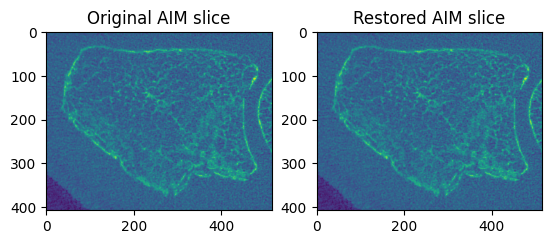

In [39]:
# for a random slice
slice_nb = 10

np_original = vtkImageData_to_numpy(aim_original)
np_restore = vtkImageData_to_numpy(aim_restore)

slice_original = np_original[:, :, slice_nb]
slice_restore = np_restore[:, :, slice_nb]

f, ax = plt.subplots(1,2)
ax[0].imshow(slice_original)
ax[0].set_title('Original AIM slice');

ax[1].imshow(slice_restore)
ax[1].set_title('Restored AIM slice');

diff = np_original - np_restore
diff_vals = np.unique(diff)
if diff_vals.all() == 0:
    print('The two numpy arrays are identical')
else:
    print('The two numpy arrays are NOT identical')